# Introduction

Air pollution is a major public health issue, especially in large cities. Among the most problematic air pollutants, nitrogen dioxide (NO₂) plays an important role because it is strongly linked to road traffic and urban activities. New Delhi is regularly ranked among the most polluted cities in the world, which makes the study of air pollution in this area particularly relevant.

The objective of this project is to develop a machine learning model able to predict the NO₂ concentration 6 hours ahead, using historical air pollution data and meteorological data. Such a prediction can help to anticipate pollution peaks and support decision making, both for citizens and public authorities.

The main dataset used in this project comes from the file city_hour.csv. It contains about 700,000 hourly measurements, collected in 26 Indian cities, with several pollutants such as NO₂, PM2.5, PM10, CO, SO₂, and others.
In this project, we chose to focus only on New Delhi in order to obtain a more homogeneous dataset and better match our prediction objective. After filtering, the final dataset contains 48,192 hourly observations, which corresponds to about 5 years of continuous measurements.

In [3]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [4]:
#we load the dataset
df = pd.read_csv("city_hour.csv")
df.head()

,City,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01 01:00:00,NaN,NaN,1.00,40.01,36.37,NaN,1.00,122.07,NaN,0.0,0.0,0.0,NaN,NaN
1,Ahmedabad,2015-01-01 02:00:00,NaN,NaN,0.02,27.75,19.73,NaN,0.02,85.90,NaN,0.0,0.0,0.0,NaN,NaN
2,Ahmedabad,2015-01-01 03:00:00,NaN,NaN,0.08,19.32,11.08,NaN,0.08,52.83,NaN,0.0,0.0,0.0,NaN,NaN
3,Ahmedabad,2015-01-01 04:00:00,NaN,NaN,0.30,16.45,9.20,NaN,0.30,39.53,153.58,0.0,0.0,0.0,NaN,NaN
4,Ahmedabad,2015-01-01 05:00:00,NaN,NaN,0.12,14.90,7.85,NaN,0.12,32.63,NaN,0.0,0.0,0.0,NaN,NaN


In [5]:
df.shape

(707875, 16)

The dataset contains hourly air pollution measurements for 26 Indian cities, with several pollutants such as NO₂, PM2.5, PM10, as well as the Air Quality Index (AQI).

In total, the dataset includes around 700,000 rows and 16 columns, which represents several years of continuous observations. This large amount of data makes it possible to perform a reliable time series analysis and to train prediction models.

In [10]:
#we focus on a single city: New Delhi
df_city = df[df["City"] == "Delhi"].copy()

df_city.shape

(48192, 16)

After filtering the dataset for the city of New Delhi, the data contains 48,192 hourly observations, which corresponds to about 5 years of continuous measurements.


## Cleaning the pollution dataset

In this section, we prepare the pollution data for the rest of the project. This includes:
- the selection of useful variables,
- the conversion of the time column into datetime format,
- the checking and treatment of missing values.


In [11]:
# we keep only Datetime and NO2
df_pollution = df_city[["Datetime", "NO2"]].copy()

#convert Datetime into a real datetime
df_pollution["Datetime"] = pd.to_datetime(df_pollution["Datetime"])

# we check missing values
df_pollution.isna().sum()

Datetime      0
NO2         330
dtype: int64

We observe the presence of 330 missing values in the NO₂ variable. These values cannot be used for training the model. Therefore, they will be removed in order to keep only usable observations.


In [12]:
df_pollution = df_pollution.dropna().reset_index(drop=True)

At this stage, the pollution data alone is not sufficient to predict the evolution of NO₂. Indeed, the date by itself does not allow a relevant prediction.

That is why we decide to enrich our data with meteorological data corresponding to the same hours. For this purpose, we use the Open-Meteo API, which allows us to retrieve historical weather data for free.


### Retrieving meteorological data via the Open-Meteo API


In [13]:
# we get the weather data via the Open-Meteo API

# coordinates of Delhi, found on dateandtime.info
latitude = 28.6139
longitude = 77.2090

# exact period of the original dataset
start_date = "2015-01-01"
end_date = "2020-07-01"

# hourly weather variables to retrieve
hourly_vars = [
    "temperature_2m",
    "relative_humidity_2m",
    "surface_pressure",
    "windspeed_10m",
    "precipitation"
]

# we build the Open-Meteo URL
url = (
    "https://archive-api.open-meteo.com/v1/archive?"
    f"latitude={latitude}&longitude={longitude}"
    f"&start_date={start_date}&end_date={end_date}"
    f"&hourly={','.join(hourly_vars)}"
    "&timezone=GMT"
)

#Permit to call the API
response = requests.get(url)
data = response.json()

#Create the weather DataFrame
df_weather = pd.DataFrame(data["hourly"])

# we convert time into datetime
df_weather["time"] = pd.to_datetime(df_weather["time"])

# we rename time into Datetime for the future merge
df_weather = df_weather.rename(columns={"time": "Datetime"})

df_weather.head()

,Datetime,temperature_2m,relative_humidity_2m,surface_pressure,windspeed_10m,precipitation
0,2015-01-01 00:00:00,12.7,81,990.5,8.3,0.0
1,2015-01-01 01:00:00,12.4,82,990.5,8.3,0.0
2,2015-01-01 02:00:00,12.0,83,991.0,8.5,0.0
3,2015-01-01 03:00:00,13.2,79,992.3,7.1,0.0
4,2015-01-01 04:00:00,15.7,68,993.1,4.8,0.0


At this stage, we now have two separate datasets:

- the first one contains the pollution measurements (NO₂) for the city of New Delhi,

- the second one contains the meteorological variables corresponding to the same hourly periods.

The objective now is to merge these two datasets using the `Datetime` column, in order to obtain a single final dataframe that includes all the information needed for the modeling.


In [14]:
#This step permits to merge the dataset
df_final = pd.merge(
    df_pollution,
    df_weather,
    on="Datetime",
    how="inner"
)

df_final.head()

,Datetime,NO2,temperature_2m,relative_humidity_2m,surface_pressure,windspeed_10m,precipitation
0,2015-01-01 01:00:00,41.78,12.4,82,990.5,8.3,0.0
1,2015-01-01 02:00:00,43.46,12.0,83,991.0,8.5,0.0
2,2015-01-01 03:00:00,41.19,13.2,79,992.3,7.1,0.0
3,2015-01-01 04:00:00,39.55,15.7,68,993.1,4.8,0.0
4,2015-01-01 05:00:00,37.41,18.1,60,993.6,5.1,0.0


In [15]:
df_final.shape

(47862, 7)

In [16]:
df_final.isna().sum()

Datetime                0
NO2                     0
temperature_2m          0
relative_humidity_2m    0
surface_pressure        0
windspeed_10m           0
precipitation           0
dtype: int64

### Merging pollution and meteorological data

The two datasets were merged using the Datetime column, which is common to both the pollution data and the meteorological data.  
This merge allows us to obtain, for each hour, both the NO₂ concentration and the corresponding weather conditions.

The final dataset now contains 47,862 observations and 7 variables and no longer has missing values.  
This final dataframe is the base used for the following exploratory data analysis and the modeling.


### Feature Engineering

The goal of feature engineering is to create new variables from the existing data in order to help the prediction model better understand the temporal structure of the studied phenomenon.

Here, we create the prediction target NO₂ at t+6h, which corresponds to a realistic short-term forecast in a real-life context. Indeed, predicting air pollution a few hours ahead is useful to anticipate pollution peaks.

We also extract time information from the Datetime column (hour, day, month and day of the week). These variables allow the model to take into account the cyclic effects related to time (daily rhythm, differences between weekdays and weekends, seasons, etc.).


In [17]:
# we create our target: NO2 at t+6h
df_final["NO2_t+6"] = df_final["NO2"].shift(-6)

# the last 6 values are NaN because of t+6h, so we remove them
df_final = df_final.dropna()

# we correctly separate the day, the hour, the month and the day of the week
df_final["hour"]=df_final["Datetime"].dt.hour
df_final["day"]=df_final["Datetime"].dt.day
df_final["month"]=df_final["Datetime"].dt.month
df_final["dayofweek"]=df_final["Datetime"].dt.dayofweek
df_final.head()

,Datetime,NO2,temperature_2m,relative_humidity_2m,surface_pressure,windspeed_10m,precipitation,NO2_t+6,hour,day,month,dayofweek
0,2015-01-01 01:00:00,41.78,12.4,82,990.5,8.3,0.0,30.97,1,1,1,3
1,2015-01-01 02:00:00,43.46,12.0,83,991.0,8.5,0.0,26.83,2,1,1,3
2,2015-01-01 03:00:00,41.19,13.2,79,992.3,7.1,0.0,26.22,3,1,1,3
3,2015-01-01 04:00:00,39.55,15.7,68,993.1,4.8,0.0,27.70,4,1,1,3
4,2015-01-01 05:00:00,37.41,18.1,60,993.6,5.1,0.0,27.13,5,1,1,3


## Exploratory Data Analysis (EDA)

Exploratory data analysis allows us to get a first understanding of the behavior of NO₂ in New Delhi. It helps to identify the distribution of the values, the periods of high pollution, as well as the possible relationships between air pollution and meteorological variables.

This step is essential before any modeling, as it allows us to check the consistency of the data, detect possible anomalies, and guide the choice of the prediction model.


### Distribution of NO₂

This graph allows us to observe the distribution of NO₂ concentrations in the air in New Delhi over the whole studied period.


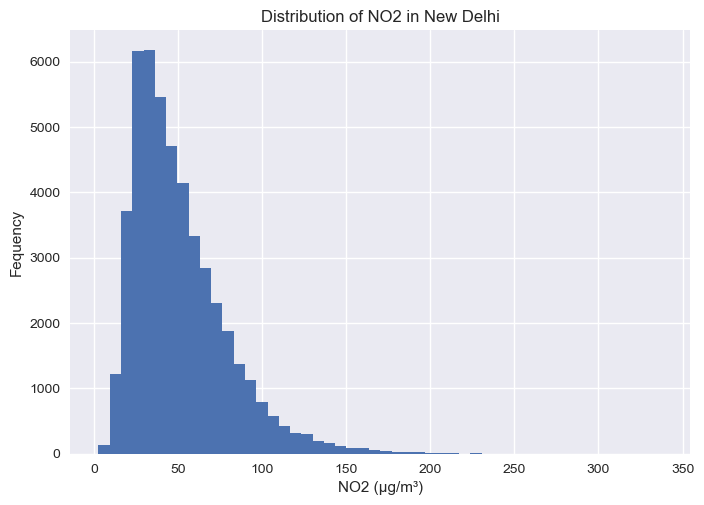

In [18]:
plt.figure()
plt.hist(df_final["NO2"], bins=50)
plt.title("Distribution of NO2 in New Delhi")
plt.xlabel("NO2 (µg/m³)")
plt.ylabel("Fequency")
plt.show()
#Display the graphic

We observe that most of the values are between about 20 and 80 µg/m³, with a few extreme peaks that can exceed 200 µg/m³.  
This shows that episodes of very high pollution are rare but do exist, which makes the prediction of these peaks particularly interesting.

### Temporal evolution of NO₂

This graph shows the evolution of NO₂ pollution over time.


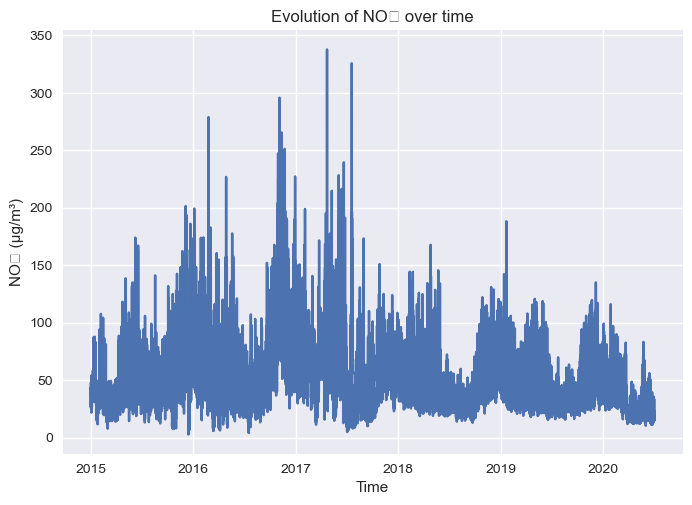

C:\Users\hadjs\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\hadjs\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\hadjs\anaconda3\Lib\site-packages\seaborn\relational.py:441: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub_data = grouped.apply(agg, other).reset_index()
C:\Users\ha

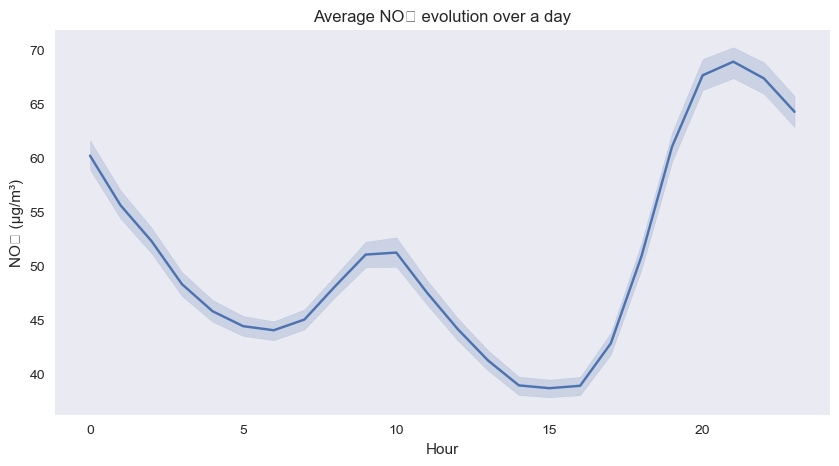

C:\Users\hadjs\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\hadjs\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\hadjs\anaconda3\Lib\site-packages\seaborn\relational.py:441: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub_data = grouped.apply(agg, other).reset_index()
C:\Users\ha

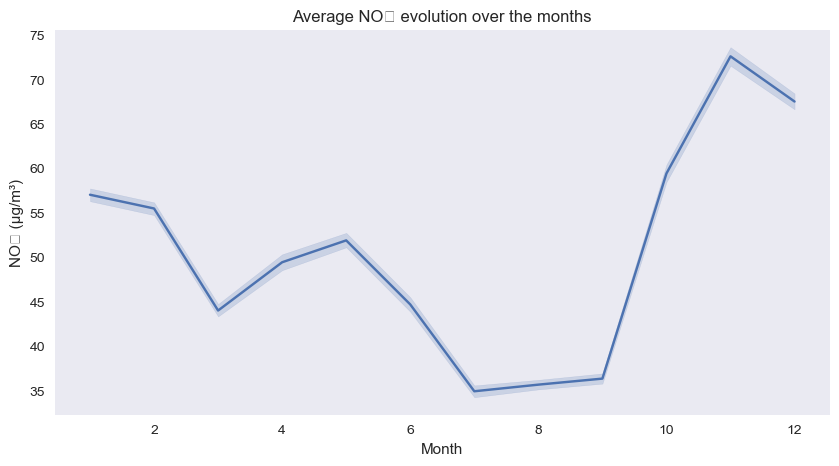

In [25]:
plt.figure()
plt.plot(df_final["Datetime"], df_final["NO2"])
plt.title("Evolution of NO₂ over time")
plt.xlabel("Time")
plt.ylabel("NO₂ (µg/m³)")
plt.show()

plt.figure(figsize=(10,5))
sns.lineplot(data=df_final, x="hour", y="NO2")
plt.title("Average NO₂ evolution over a day")
plt.xlabel("Hour")
plt.ylabel("NO₂ (µg/m³)")
plt.grid()
plt.show()

plt.figure(figsize=(10,5))
sns.lineplot(data=df_final, x="month", y="NO2")
plt.title("Average NO₂ evolution over the months")
plt.xlabel("Month")
plt.ylabel("NO₂ (µg/m³)")
plt.grid()
plt.show()


The first graph shows that NO₂ concentrations vary strongly over time, with frequent peaks, highlighting the unstable and critical nature of air pollution in New Delhi. The daily pattern reveals two main peaks, one in the morning and a stronger one in the evening, which are likely linked to traffic activity. The monthly evolution shows that pollution is significantly higher during winter months and much lower in summer. This confirms the strong influence of both human activity and seasonal meteorological conditions on NO₂ levels

### Impact of Meteorological Variables on NO₂ Concentration

To better understand how weather conditions influence air pollution, we analyzed the relationship between NO₂ concentration and several meteorological variables such as temperature, humidity, wind speed, and atmospheric pressure.

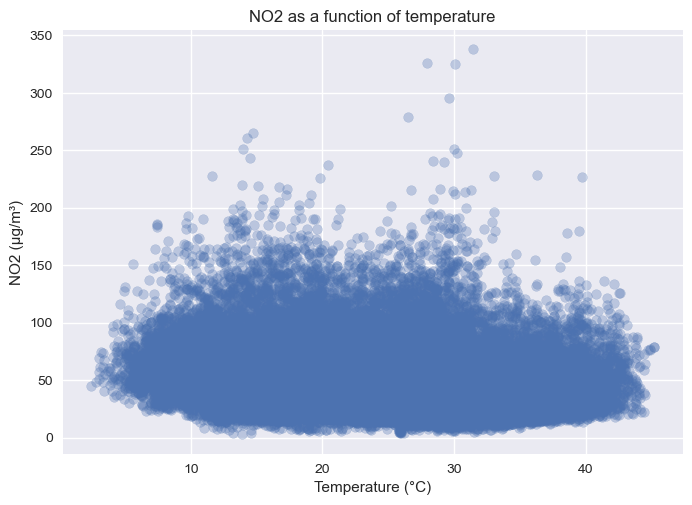

C:\Users\hadjs\AppData\Local\Temp\ipykernel_80012\3305437367.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


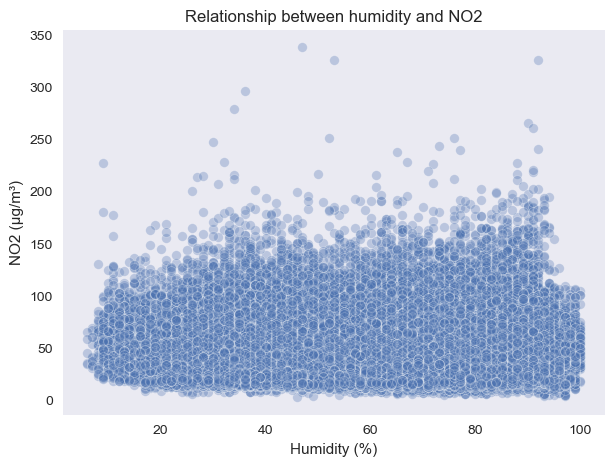

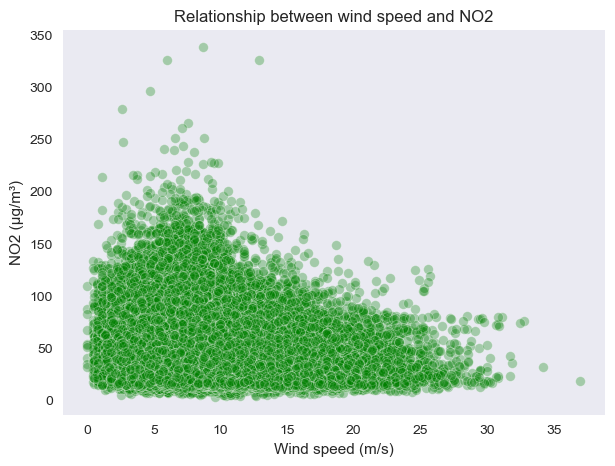

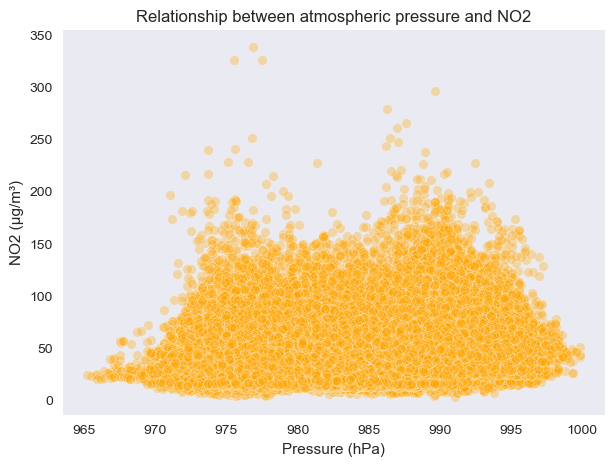

In [27]:
plt.figure()
plt.scatter(df_final["temperature_2m"], df_final["NO2"], alpha=0.3)
plt.title("NO2 as a function of temperature")
plt.xlabel("Temperature (°C)")
plt.ylabel("NO2 (µg/m³)")
plt.show()

plt.style.use("seaborn")

plt.figure(figsize=(7,5))
sns.scatterplot(data=df_final, x="relative_humidity_2m", y="NO2", alpha=0.3)
plt.title("Relationship between humidity and NO2")
plt.xlabel("Humidity (%)")
plt.ylabel("NO2 (µg/m³)")
plt.grid()
plt.show()

plt.figure(figsize=(7,5))
sns.scatterplot(data=df_final, x="windspeed_10m", y="NO2", alpha=0.3, color="green")
plt.title("Relationship between wind speed and NO2")
plt.xlabel("Wind speed (m/s)")
plt.ylabel("NO2 (µg/m³)")
plt.grid()
plt.show()

plt.figure(figsize=(7,5))
sns.scatterplot(data=df_final, x="surface_pressure", y="NO2", alpha=0.3, color="orange")
plt.title("Relationship between atmospheric pressure and NO2")
plt.xlabel("Pressure (hPa)")
plt.ylabel("NO2 (µg/m³)")
plt.grid()
plt.show()


These graphs show that the relationship between NO₂ and meteorological variables is highly non-linear. NO₂ does not follow a clear linear trend with temperature or humidity, which confirms the complexity of the pollution phenomenon. Wind speed has a strong negative influence on NO₂: when wind speed increases, NO₂ concentrations clearly decrease due to the dispersion of pollutants. Atmospheric pressure also shows a structured pattern, with higher NO₂ levels occurring under stable pressure conditions. These observations justify the use of a non-linear model such as Random Forest instead of a simple linear regression.

### Correlation between variables

This correlation matrix allows us to measure the relationships between NO₂ and the different meteorological and temporal variables.

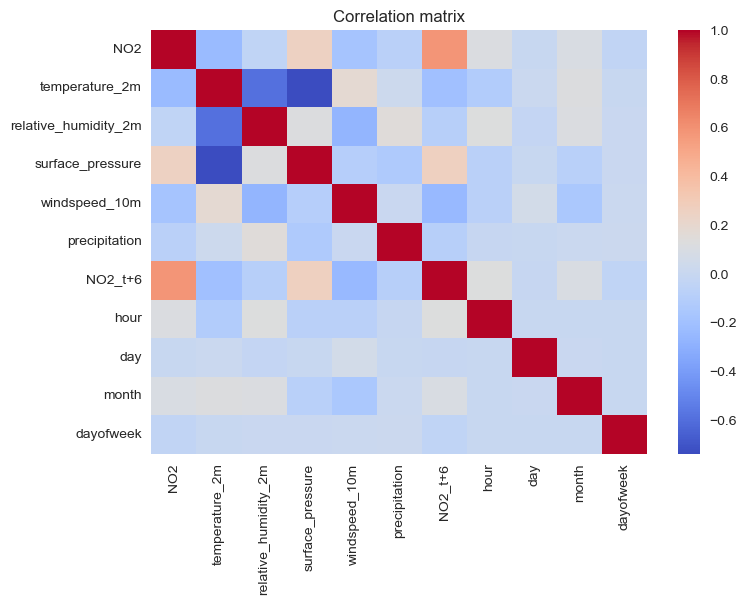

In [21]:
plt.figure()
corr = df_final.corr(numeric_only=True)
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Correlation matrix")
plt.show()

We observe that the correlation between NO₂ and the other variables remains globally weak to moderate.  
This confirms that the pollution phenomenon is complex and depends on several combined factors, which justifies the use of a non-linear machine learning model.

The exploratory analysis shows that the NO₂ concentration has a strong temporal variability, with clear pollution peaks and seasonal effects. The relationships with the meteorological variables are complex and non-linear. These observations confirm the need to use a non-linear prediction model and to include several explanatory variables.


### Data preparation for modeling

Before training a prediction model, it is necessary to clearly define:
- the explanatory variables which are used as inputs for the model,
- and the target variable which is the value we want to predict.

In our case, the explanatory variables include the meteorological data as well as temporal information (hour, day, month, day of the week).  
The target variable corresponds to the NO₂ concentration 6 hours later (NO2_t+6).


In [61]:
# explanatory variables
X = df_final[
    [
        "temperature_2m",
        "relative_humidity_2m",
        "surface_pressure",
        "windspeed_10m",
        "precipitation",
        "hour",
        "day",
        "month",
        "dayofweek"
    ]
]

# target
y = df_final["NO2_t+6"]
X.shape, y.shape

((47856, 9), (47856,))

In [62]:
split_index = int(len(df_final) * 0.8)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

X_train.shape, X_test.shape

((38284, 9), (9572, 9))

In [63]:
# training
model = LinearRegression()
model.fit(X_train, y_train)

# predictions
y_pred = model.predict(X_test)

# evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

mae, rmse, r2

(17.26269494823168, 20.847952551439825, -0.2757005002395989)

### Interpretation of the linear model results

The performance obtained with the linear regression is relatively weak, with a high error and a coefficient of determination (R²) close to 0, or even negative. This means that the model explains the variance of NO₂ at +6 hours very poorly.

This result shows that the relationship between NO₂ pollution and meteorological variables is not simply linear. Moreover, air pollution is a strongly temporal phenomenon, influenced by its own past values. Weather data alone is therefore not sufficient to capture the full dynamics of NO₂.

It is therefore necessary to enrich the data with information from past NO₂ values and to use a model able to capture non-linear relationships.


### Adding temporal NO₂ variables

In order to better take into account the temporal dimension of the problem, we now add variables that contain the NO₂ history:

- the current NO₂ value,
- the value one hour before (t-1),
- the value six hours before (t-6).

These variables allow the model to directly observe the recent dynamics of air pollution, which is essential to predict its short-term evolution.


In [65]:
# we create past NO2 variables
df_final["NO2_t"] = df_final["NO2"]
df_final["NO2_t-1"] = df_final["NO2"].shift(1)
df_final["NO2_t-6"] = df_final["NO2"].shift(6)

#Verification
df_final[["Datetime", "NO2", "NO2_t", "NO2_t-1", "NO2_t-6"]].head(10)

# we remove null values
df_final = df_final.dropna()

In [67]:
X = df_final[
    [
        "temperature_2m",
        "relative_humidity_2m",
        "surface_pressure",
        "windspeed_10m",
        "precipitation",
        "hour",
        "day",
        "month",
        "dayofweek",
        "NO2_t",
        "NO2_t-1",
        "NO2_t-6"
    ]
]

y = df_final["NO2_t+6"]
X.head(10)

,temperature_2m,relative_humidity_2m,surface_pressure,windspeed_10m,precipitation,hour,day,month,dayofweek,NO2_t,NO2_t-1,NO2_t-6
6,20.8,49,992.7,7.6,0.0,7,1,1,3,30.97,32.06,41.78
7,21.0,47,991.8,6.0,0.0,8,1,1,3,26.83,30.97,43.46
8,21.3,46,991.1,4.7,0.0,9,1,1,3,26.22,26.83,41.19
9,21.3,46,990.9,3.4,0.0,10,1,1,3,27.70,26.22,39.55
10,20.5,52,990.1,2.4,0.0,11,1,1,3,27.13,27.70,37.41
11,19.6,56,990.8,5.4,0.0,12,1,1,3,26.91,27.13,32.06
12,18.1,62,990.9,7.1,0.0,13,1,1,3,27.59,26.91,30.97
13,17.1,66,991.8,8.1,0.0,14,1,1,3,27.83,27.59,26.83
14,16.4,69,992.0,6.9,0.0,15,1,1,3,32.57,27.83,26.22
15,15.9,73,992.3,6.6,0.0,16,1,1,3,37.08,32.57,27.70


In [68]:
split_index = int(len(df_final) * 0.8)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

X_train.shape, X_test.shape

((38280, 12), (9570, 12))

In [72]:
results = []

#BASELINE 
y_baseline = X_test["NO2_t"]  # prédire NO2(t+6) ≈ NO2(t)

mae_baseline = mean_absolute_error(y_test, y_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_baseline))
r2_baseline = r2_score(y_test, y_baseline)

results.append(["Baseline (NO2(t))", mae_baseline, rmse_baseline, r2_baseline])

#LINEAR REGRESION 
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

y_pred_lin = lin_model.predict(X_test)

mae_lin = mean_absolute_error(y_test, y_pred_lin)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
r2_lin = r2_score(y_test, y_pred_lin)

results.append(["Régression linéaire", mae_lin, rmse_lin, r2_lin])

#RANDOM FOREST 
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

results.append(["Random Forest", mae_rf, rmse_rf, r2_rf])

#RESULTS TABLE
df_results = pd.DataFrame(results, columns=["Modèle", "MAE", "RMSE", "R²"])
df_results

,Modèle,MAE,RMSE,R²
0,Baseline (NO2(t)),12.307336,17.129741,0.138461
1,Régression linéaire,11.124994,14.123317,0.414338
2,Random Forest,7.550496,9.828380,0.716380


### Analysis of model performances

The results table highlights significant differences in performance between the tested models.  
The baseline model which simply consists of predicting the future NO₂ value from its current value, provides a first reference with an average error (MAE) of about 12.3 µg/m³ and a low coefficient of determination R² (0.14). This shows that this approach remains very limited and does not correctly capture the real dynamics of pollution.

The linear regression clearly improves the performance, with a MAE of about 11.1 µg/m³ and an R² of 0.41. This improvement shows that meteorological variables do bring useful information for predicting NO₂. However, the performance is still moderate, which suggests that the relationship between the variables is not strictly linear.

The Random Forest model achieves the best results, with a MAE of 7.55 µg/m³, a RMSE of 9.83 µg/m³, and especially a high R² of 0.72. These results show that the model manages to explain a large part of the variability of NO₂. This confirms the non-linear nature of the problem and the interest of using a more complex model to capture the interactions between meteorological variables, temporal variables, and past pollution.

Based on these results, the Random Forest is chosen as the final model, because it offers the best balance between accuracy and generalization ability.


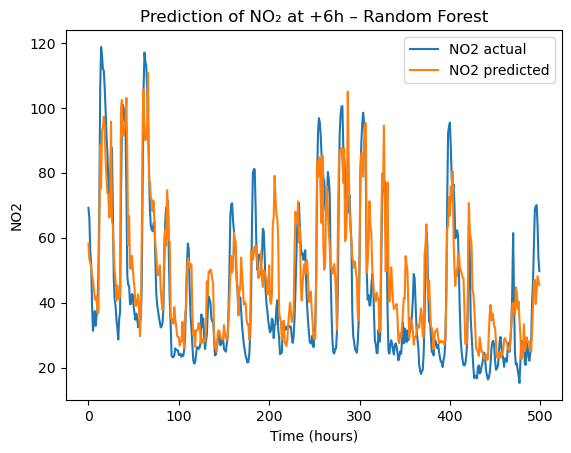

In [78]:
df_plot = pd.DataFrame({
    "NO2_reel": y_test.reset_index(drop=True),
    "NO2_predit": y_pred_rf
})

plt.figure()
plt.plot(y_test.values[:500], label="NO2 actual")
plt.plot(y_pred_rf[:500], label="NO2 predicted")
plt.xlabel("Time (hours)")
plt.ylabel("NO2")
plt.title("Prediction of NO₂ at +6h – Random Forest")
plt.legend()
plt.show()

### Comparison between real and predicted values

This graph compares the real NO₂ values with the values predicted by the Random Forest model over a time window of 500 hours. We can see that the model is able to follow the global dynamics of the signal quite well, with consistent variations between the real and predicted curves.

The pollution peaks are generally well detected, even if some extreme values are slightly underestimated. Overall, this result is consistent with the good performances previously obtained with the metrics (MAE, RMSE, and R²).

This graph therefore visually confirms that the Random Forest model is able to effectively predict the short-term evolution of NO₂ (+6 hours).


## Conclusion

In this project, we aimed to predict the NO₂ concentration at +6 hours using air pollution data and meteorological data for the city of New Delhi. After a phase of data cleaning and preparation, we enriched our dataset with weather variables obtained from the Open-Meteo API, which allowed us to obtain a final dataset that is coherent and usable.

The exploratory data analysis highlighted a strong variability of NO₂, with significant pollution peaks and a clear influence of time, seasons, and weather conditions. The graphs and the correlation matrix confirmed that the relationship between NO₂ and meteorological variables is complex and non-linear, which justifies the use of more advanced models than simple linear regression.

Three approaches were compared:

- a very simple baseline model,

- a linear regression model,

- and a Random Forest model.

The results show that the Random Forest is by far the most performant, with a lower error and a high coefficient of determination, meaning that it is able to explain a large part of the variability of NO₂. The graph comparing real and predicted values also visually confirms the good quality of the predictions.

Finally, this work fully fits into a Green AI approach, with reasonable model choices, a concrete environmental objective (air pollution prediction), and a possible application for decision support, health prevention, or citizen information.  
This project therefore shows how artificial intelligence can be used to address real and current environmental issues.
